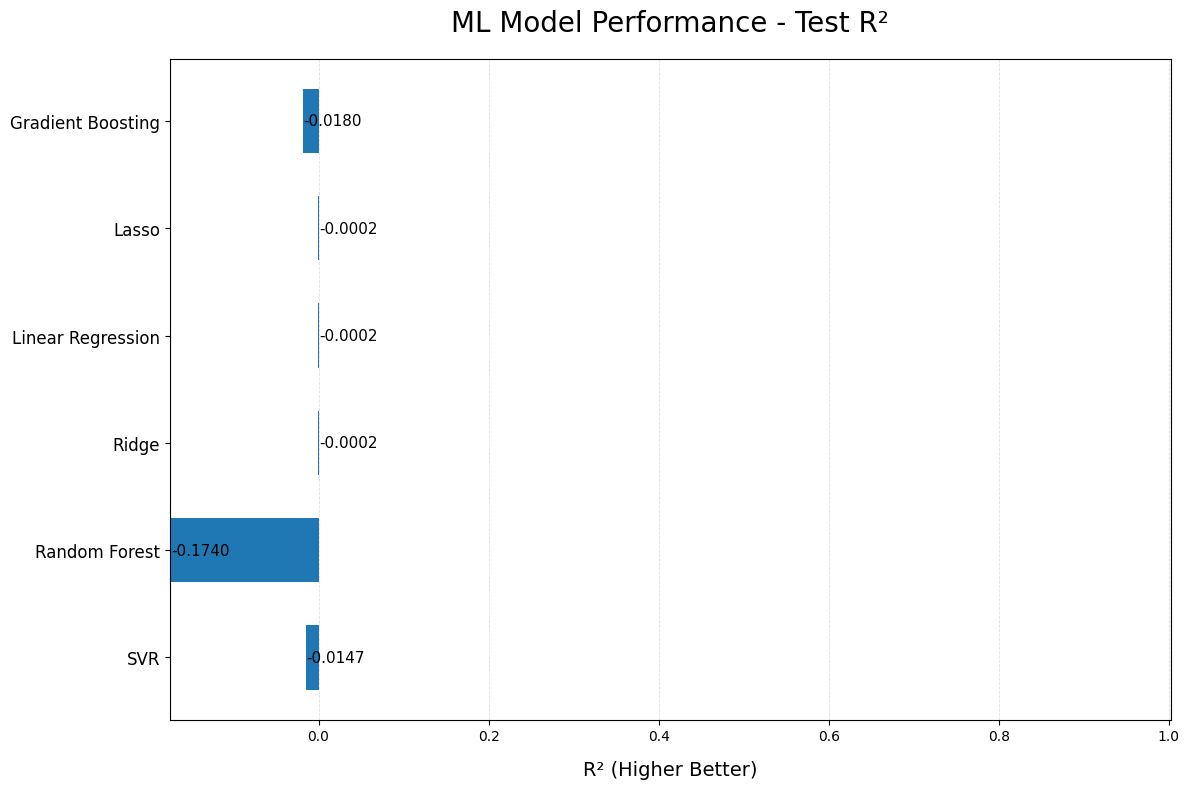

R2 scores: {'Gradient Boosting': -0.018032637745774682, 'Lasso': -0.0001677062242313454, 'Linear Regression': -0.00019685203176034172, 'Ridge': -0.0001958205915595368, 'Random Forest': -0.17399194245464566, 'SVR': -0.014719322432724447}
Best model saved as best_model.joblib -> Lasso


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import joblib
import matplotlib.pyplot as plt

# Corrected CSV path to match the one successfully loaded earlier
csv_path = "Household dataset - Week 1.csv"
df = pd.read_csv(csv_path)

# The original code expected a 'timestamp' column for feature extraction
# Let's recreate 'timestamp', 'hour', 'dayofweek' from 'Date' and 'Time'
if 'Date' in df.columns and 'Time' in df.columns:
    df['timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek

# The original code expected an 'energy_kwh' column.
# Based on available columns, let's use 'Global_active_power' as a placeholder for 'energy_kwh'.
# You can change this to 'Sub_metering_1', 'Sub_metering_2', or 'Sub_metering_3' if more appropriate.
if 'energy_kwh' not in df.columns:
    df['energy_kwh'] = df['Global_active_power'] # Using Global_active_power as energy_kwh

# Fill in missing required columns with default values if they don't exist
# Note: these default values are placeholders. For better model performance,
# actual data for these features would be ideal.
required_cols = ["hour","dayofweek","temperature","humidity","occupancy","energy_kwh"]
for c in required_cols:
    if c not in df.columns:
        if c == "temperature": df[c] = df.get(c, 25.0) # Default to 25.0 Celsius
        elif c == "humidity": df[c] = df.get(c, 60.0)    # Default to 60.0% humidity
        elif c == "occupancy": df[c] = df.get(c, 1)      # Default to 1 (occupied)

# Create 'is_weekend' feature
df['is_weekend'] = (df['dayofweek'].astype(int) >= 5).astype(int) # Convert boolean to int

# Create 'prev_energy' feature
if 'prev_energy' not in df.columns:
    df['prev_energy'] = df['energy_kwh'].shift(1).fillna(df['energy_kwh'].mean())

# Define features and target variable
features = ["hour","dayofweek","temperature","humidity","occupancy","is_weekend","prev_energy"]
X = df[features].astype(float)
y = df["energy_kwh"].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

models = [
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42)),
    ("Lasso", Lasso(random_state=42)),
    ("Linear Regression", LinearRegression()),
    ("Ridge", Ridge(random_state=42)),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
    ("SVR", make_pipeline(StandardScaler(), SVR()))
]

scores = {}
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores[name] = r2_score(y_test, y_pred)

model_names = [name for name, _ in models] # Get model names in order
r2_values = [scores[n] for n in model_names]

best_model_name = max(scores, key=scores.get)
best_model = dict(models)[best_model_name]
joblib.dump(best_model, "best_model.joblib")

fig, ax = plt.subplots(figsize=(12, 8))
y_pos = np.arange(len(model_names))
bars = ax.barh(y_pos, r2_values, height=0.6)
ax.set_yticks(y_pos)
ax.set_yticklabels(model_names, fontsize=12)
ax.invert_yaxis()
ax.set_xlim(min(r2_values) - 0.001, 1.002)
ax.set_xlabel("R² (Higher Better)", fontsize=14, labelpad=12)
ax.set_title("ML Model Performance - Test R²", fontsize=20, pad=20)
for bar, val in zip(bars, r2_values):
    ax.text(bar.get_width() + 0.0006, bar.get_y() + bar.get_height() / 2, f"{val:.4f}", va='center', fontsize=11)
ax.grid(axis='x', linestyle='--', linewidth=0.6, alpha=0.4)
plt.tight_layout()
plt.savefig("model_r2_bar.png", dpi=300, bbox_inches='tight')
plt.show()

print("R2 scores:", scores)
print("Best model saved as best_model.joblib ->", best_model_name)
